# Проект e-commerce: вариант 1 
# Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы

In [1]:
# Импортируем библиотеки
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import timedelta
from operator import attrgetter

# Для визуализации графика в юпитерхабе
%matplotlib inline 

In [2]:
# Загружаем датасеты по ссылке на яндекс диске
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Ссылки на наши датасеты на яндекс диске
public_key1 = 'https://yadi.sk/d/QXrVDUoQvFhIcg' 
public_key2 = 'https://yadi.sk/d/0zWmh1bYP6REbw'
public_key3 = 'https://yadi.sk/d/xCsQ0FiC-Ue4Lg'

# Получаем загрузочные ссылки
final_url1 = base_url + urlencode(dict(public_key = public_key1))
final_url2 = base_url + urlencode(dict(public_key = public_key2))
final_url3 = base_url + urlencode(dict(public_key = public_key3))

response1 = requests.get(final_url1)
response2 = requests.get(final_url2)
response3 = requests.get(final_url3)

download_url1 = response1.json()['href']
download_url2 = response2.json()['href']
download_url3 = response3.json()['href']

# Загружаем файлы в df 
download_response1 = requests.get(download_url1) 
download_response2 = requests.get(download_url2) 
download_response3 = requests.get(download_url3) 

customers   = pd.read_csv(download_url1, sep = ',') 
orders      = pd.read_csv(download_url2, sep = ',') 
order_items = pd.read_csv(download_url3, sep = ',') 

Взглянем на наши df и проверим их на пропуски:

In [3]:
# Таблица с уникальными идентификаторами пользователей:
# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя (аналог номера паспорта)
# customer_zip_code_prefix — почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Пропущенных значений нет

In [5]:
# Таблица заказов:
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Есть пропуски в колонках: 
- order_approved_at (т.е. заказ не был оплачен)
- order_delivered_carrier_date (заказ не был передан в логистическую службу) 
- order_delivered_customer_date (заказ не был доставлен)

Это означает, что не все заказы успешно завершены

In [7]:
# Исправим некорректный для дат тип данных
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
        'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 'order_approved_at', 
                                                    'order_delivered_carrier_date', 'order_delivered_customer_date', 
                                                    'order_estimated_delivery_date']].apply(pd.to_datetime )
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [8]:
# Товарные позиции, входящие в заказы:
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Пропущенных значений нет

In [10]:
# Исправим некорректный для дат тип данных
order_items[['shipping_limit_date']] = order_items[['shipping_limit_date']].apply(pd.to_datetime )
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


**Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. 
Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.**

In [11]:
# Можно предположить, что заказы, имеющие значение order_approved_at —  время подтверждения оплаты заказа, считаются покупкой
# Проверим статусы таких заказов
orders.query('order_approved_at != "NaN"').order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'approved'], dtype=object)

Видим, что заказы со всеми имеющимися статусами, кроме "created", имеют дату оплаты
Делаем вывод, что такое предположение не совсем корректно, разве можно считать покупкой заказ со статусом "unavailable"?

In [12]:
# Проверим, заказы с какими статусами не имеют значения в колонке order_approved_at
orders.query('order_approved_at == "NaN"').order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

Со статусами "закрыт" и "создан" понятно, их за покупку точно не считаем,
но как доставленный заказ ("delivered") может не содержать дату оплаты?

In [13]:
# Посмотрим поподробнее на такие заказы, объединив их с df order_items, а затем с customers
orders_delivered_not_approved = orders.query('order_approved_at == "NaN" and order_status == "delivered"')
df = orders_delivered_not_approved.merge(order_items, on = 'order_id', how = 'left')
df_full = df.merge(customers, on = 'customer_id', how = 'left')
df_full

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,2017-02-22 13:40:00,309.90,39.11,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP
1,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,1,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,2017-02-22 11:45:31,379.00,17.86,91efb7fcabc17925099dced52435837f,93548,novo hamburgo,RS
2,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53,e1f01a1bd6485e58ad3c769a5427d8a8,8230,sao paulo,SP
3,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE
4,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ
5,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,1,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-23 12:48:08,39.99,14.52,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP
6,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,1,cae2e38942c8489d9d7a87a3f525c06b,cca3071e3e9bb7d12640c9fbe2301306,2017-02-26 01:28:47,149.80,13.63,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP
7,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,1,02a79d79e818ad0be36cfc843a6af7ad,cb3dd9ce66268c7a3ca7241ac70ab58c,2017-02-25 10:04:19,28.99,10.96,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP
8,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG
9,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG


По итогу видим, что таких заказов всего 14, и между собой они не имеют какой-то особой взаимосвязи, у всех товаров есть цена
Вероятно, оплата задерживается из-за длительной транзакции или какой-то подобной проблемы

Тогда обращать внимание на order_approved_at опрометчиво, выберем наши покупки только исходя из статуса заказа

**Примем решение, что заказ считается покупкой, когда он уже либо собирается (т.е. он точно не недоступен),
либо уже отбыл к своему заказчику, т.е. order_status будет "delivered", "shipped" и "processing"**

# 1. Сколько у нас пользователей, которые совершили покупку только один раз? (считаем покупка = заказ)

In [14]:
# Объединим датафреймы с пользователями и заказами. Число строк в df одинаковое и нет пропусков в customer_id, 
# поэтому объединяем how = 'inner'
customers_orders = customers.merge(orders, on = 'customer_id', how = 'inner') 

In [15]:
# Считаем заказы с отобранными нами ранее статусами ('processing', 'shipped', 'delivered') 
# с группировкой по уникальным пользователям ('customer_unique_id') и выбираем тех, у кого 1 заказ (count = 1).
customers_orders.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .query('order_id == 1') \
    .count() \
    .customer_unique_id

91814

Ответ: 91814 пользователей совершили покупку только один раз

In [16]:
# Давайте еще посчитаем пользователей с одной покупкой без уточнения статуса заказа, т.е. просто с одним заказом
customers_orders.groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .query('order_id == 1') \
    .count() \
    .customer_unique_id 

93099

Получается, не так много строк вы вырезали нашим условием по статусу заказа, количество увеличилось всего на 1285 человек,
Можно сделать вывод, что большинство пользователей все-таки успешно доходят до покупки, конверсия в покупателя большая.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [17]:
# Посмотрим, какие у нас есть статусы заказов
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [18]:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [19]:
# Проверим, есть ли у нас дубли заказов с одним order_id, но с разными статусами
orders.groupby('order_id')\
    .agg({'order_status':'count'}) \
    .order_status.unique() 

array([1])

Таких заказов нет, все order_id имеют единственный статус

In [20]:
# Что будем считать "не доставленным" заказом?
# У нас есть стоблец order_delivered_customer_date с датой доставки, в котором есть пропуски. Посчитаем их
orders.query('order_delivered_customer_date == "NaN"').order_id.count()

2965

In [21]:
# И также посмотрим, сколько заказов останется, если мы исключим статус "delivered"
orders.query('order_status != "delivered"').order_id.count()

2963

In [22]:
# Есть незначительные различия в полученных числах, посмотрим, что это за доставленные заказы без даты доставки
orders.query('order_delivered_customer_date == "NaN" and order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [23]:
# Возможно, так получилось из-за какого-то сервисного сбоя, заказ еще не дошел, но статус уже сменился
# Попробуем объединить два условия, возьмём все заказы без даты доставки со статусом, отличным от "delivered"
orders.query('order_delivered_customer_date == "NaN" and order_status != "delivered"').order_id.count()

2957

In [24]:
# Далее в этом задании будем работать с данным датафреймом
not_delivered_orders = orders.query('order_delivered_customer_date == "NaN" and order_status != "delivered"')

In [25]:
# Посчитаем среднее (mean) число не доставленных заказов (not_delivered_orders) в месяц c разбивкой по статусу заказа

# Ключом для группировки будем считать обещанную дату доставки (order_estimated_delivery_date), точнее ее месяц 
# - это сделаем с помощью pd.Grouper и указания ежемесячной частоты (freq = 'M'), также сгруппируем по статусу заказа
# Посчитаем число заказов в каждой группе, снова сгруппируем только по статусу заказа, 
# и посчитаем уже среднее по месяцам число заказов, отсортировав полученные данные по убыванию
mean_not_delivered_orders = not_delivered_orders \
    .groupby([pd.Grouper(freq = 'M', key = 'order_estimated_delivery_date'),'order_status'], as_index = False) \
    .agg({'order_id' : 'count'}) \
    .groupby('order_status', as_index = False)\
    .agg({'order_id' : 'mean'}) \
    .rename(columns = {'order_id' : 'mean_count'}) \
    .sort_values('mean_count', ascending = False)

# Таблица - среднее количество заказов в месяц, которые не доставляются по разным причинам
mean_not_delivered_orders

,order_status,mean_count
5,shipped,48.130435
6,unavailable,29.000000
1,canceled,23.807692
4,processing,15.842105
3,invoiced,14.952381
2,created,1.666667
0,approved,1.000000


Text(0.5, 1.0, 'Average count of not delivered orders due to various reasons\n')

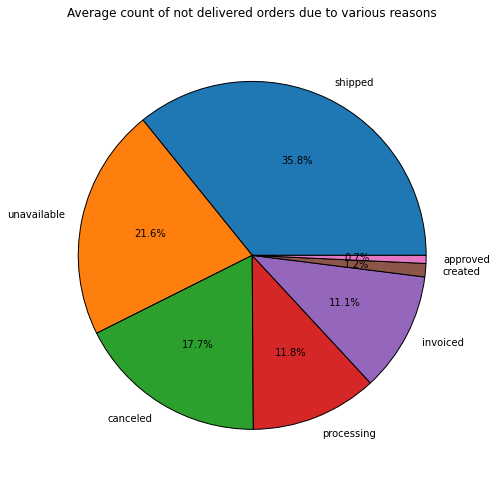

In [26]:
# Для большей наглядности выведем mean_not_delivered_orders с причинами не доставленных товаров в виде круговой диаграммы
fig, ax = plt.subplots(figsize = (8, 8))
ax.pie(mean_not_delivered_orders.mean_count, labels = mean_not_delivered_orders.order_status, 
       autopct = '%1.1f%%', wedgeprops = {'lw':1, 'ls':'-','ec':"k"})
plt.title('Average count of not delivered orders due to various reasons\n')

Согласно полученным результатам статусы заказов с наибольшим процентом отсутствия доставки 
- shipped (35.8% или 48 заказ в месяц в среднем)
- unvailable (21.6% или 29 заказов) 
- canceled (17.7% или 24 заказа)

In [27]:
# Попробуем объединить статусы заказов по предполагаемой стороне причины не доставки:
# Проблема со стороны сервиса - shipped, processing, unavailable
# Проблема со стороны покупателя - created, approved, invoiced, canceled
def causer(x):
    if x == "shipped" or x == "processing" or x == "unavailable":
        return 'service'
    else:
         return 'customer'

mean_not_delivered_orders['causer'] = mean_not_delivered_orders.apply(lambda x: causer(x['order_status']), axis =  1)
mean_not_delivered_orders

,order_status,mean_count,causer
5,shipped,48.130435,service
6,unavailable,29.000000,service
1,canceled,23.807692,customer
4,processing,15.842105,service
3,invoiced,14.952381,customer
2,created,1.666667,customer
0,approved,1.000000,customer


In [28]:
# И посчитаем сумму не доставленных заказов с разбивкой по "виновникам"
causer_not_delivery = mean_not_delivered_orders.groupby('causer', as_index = False) \
    .agg({'mean_count' : 'sum'})
causer_not_delivery

,causer,mean_count
0,customer,41.42674
1,service,92.97254


Text(0.5, 1.0, 'Average count of not delivered orders due to causer\n')

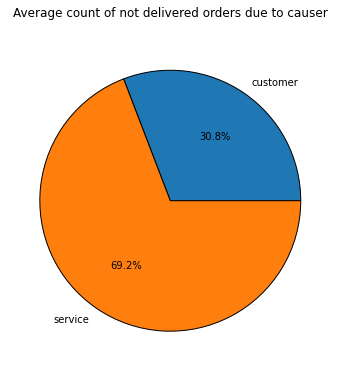

In [29]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.pie(causer_not_delivery.mean_count, labels = causer_not_delivery.causer, 
       autopct = '%1.1f%%', wedgeprops = {'lw':1, 'ls':'-','ec':"k"})
plt.title('Average count of not delivered orders due to causer\n')

В результате видим, что почти в 70% случаев заказ не доставлен по вине сервиса - это может быть сбой в системе,
отсутствие товара, ошибка в логистике и т.д. 

In [30]:
# Cделаем еще распределение заказов по всем статусам в общем по начальному датафрейму
orders_count = orders.groupby('order_status', as_index = False) \
    .agg({'order_id': 'count'}) \
    .rename(columns = {'order_id' : 'order_count'}) \
    .sort_values('order_count', ascending = False)
orders_count

,order_status,order_count
3,delivered,96478
6,shipped,1107
1,canceled,625
7,unavailable,609
4,invoiced,314
5,processing,301
2,created,5
0,approved,2


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [31]:
# Нам нужны данные по товарам и по их доставке, поэтому объединяем df orders и order_items
# Пропуски не нужны, поэтому объединяем по совпадающим строкам

orders_and_items = orders.merge(order_items, on = 'order_id') 

In [32]:
# Используем дату подтверждения оплаты заказа (order_approved_at), т.к. именно тогда происходит покупка
# Модифицируем ее в день недели

orders_and_items['order_approved_day'] = orders_and_items.order_approved_at.dt.day_name()

In [33]:
# Узнаем, в какой день недели каждый товар чаще всего покупается:
# Выберем заказы нужного статуса, сгруппируем их по product_id и дню недели,
# посчитаем число заказов в каждой группе и отсортируем по убыванию числа заказов

# Так как нам нужны дни, в которых заказ покупается чаще всего, то оставляем только первое упоминание каждого product_id
# И переименуем колонки согласно их изменениям

items_approved_day = orders_and_items.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['product_id','order_approved_day'], as_index = False) \
    .agg({'order_status' : 'count'}) \
    .sort_values('order_status', ascending = False) \
    .drop_duplicates(subset = ['product_id'], keep = 'first') \
    .rename(columns = {'order_approved_day' : 'top_approved_day', 'order_status' : 'orders_count'}) 

items_approved_day

,product_id,top_approved_day,orders_count
40699,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
19963,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15791,422879e10f46682990de24d770e7f83d,Tuesday,89
36222,99a4788cb24856965c36a24e339b6058,Tuesday,82
12952,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23767,63f916d8413bc439687d549e937d5b67,Saturday,1
23768,63f9b908e4626ece2e47cec24ff8dd9c,Thursday,1
23769,6400587d9225c4ea09f3d5ae53860c11,Tuesday,1
23770,6401d2f82d6e6c52998ce626fe4eda24,Tuesday,1


Кажется, покупатели больше всего готовы тратить деньги по вторникам

In [34]:
# Давайте еще посмотрим, как в целом распределялось количество заказов по дням недели
# Не забудем сделать сортировку по дням недели

week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

orders_count_day = orders_and_items.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby('order_approved_day', as_index = False) \
    .agg({'order_status' : 'count'}) \
    .rename(columns = {'order_approved_day' : 'week_day', 'order_status' : 'approved_orders_count'}) \
    .set_index('week_day') \
    .reindex(week) \
    .reset_index()

orders_count_day

,week_day,approved_orders_count
0,Monday,14534
1,Tuesday,21599
2,Wednesday,17735
3,Thursday,17545
4,Friday,16604
5,Saturday,13719
6,Sunday,9988


In [35]:
# Еще хочется посмотреть, сильно ли различаются распределения заказов между датой оплаты заказа и датой создания заказа

orders_and_items['order_purchase_day'] = orders_and_items.order_purchase_timestamp.dt.day_name()

orders_count_day_purchase = orders_and_items.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby('order_purchase_day', as_index = False) \
    .agg({'order_status' : 'count'}) \
    .rename(columns = {'order_purchase_day' : 'week_day', 'order_status' : 'purchase_orders_count'}) \
    .set_index('week_day') \
    .reindex(week) \
    .reset_index()

orders_count_day_purchase

,week_day,purchase_orders_count
0,Monday,18227
1,Tuesday,18070
2,Wednesday,17477
3,Thursday,16639
4,Friday,15936
5,Saturday,12072
6,Sunday,13318


In [36]:
orders_count_day = orders_count_day.merge(orders_count_day_purchase, on = 'week_day')
orders_count_day

,week_day,approved_orders_count,purchase_orders_count
0,Monday,14534,18227
1,Tuesday,21599,18070
2,Wednesday,17735,17477
3,Thursday,17545,16639
4,Friday,16604,15936
5,Saturday,13719,12072
6,Sunday,9988,13318


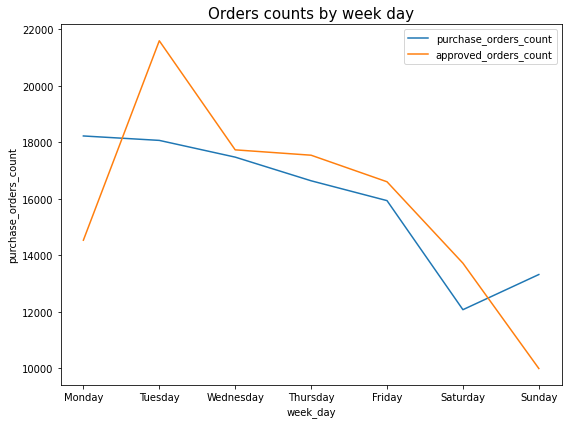

In [37]:
# Визуализируем полученные данные 

fig, ax = plt.subplots(figsize = (8, 6))
sns.lineplot(data=orders_count_day, x = 'week_day', y = 'purchase_orders_count', label = 'purchase_orders_count')
sns.lineplot(data=orders_count_day, x = 'week_day', y = 'approved_orders_count', label = 'approved_orders_count')
ax.set_title('Orders counts by week day', fontsize = 15)
plt.tight_layout()

В основном пользователи делают заказ и оплачивают его в один день, выбивается только воскресенье, понедельник и вторник.
Видим, что во вторник идет большой скачок по количеству оплат, к концу недели наблюдаем спад

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? (покупка = заказ)

**Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

In [38]:
# Нас интересуют пользователи и их заказы, объединим все датафреймы в новый
customers_orders_items = customers_orders.merge(order_items, on = 'order_id')

# Берем из даты покупки только месяц (берем дату подтверждения оплаты)
customers_orders_items['order_approved_month'] = customers_orders_items.order_approved_at.dt.strftime('%Y-%m')

# И добавим еще столбец с количеством недель в каждом месяце
customers_orders_items['weeks_count'] = customers_orders_items.order_approved_at.dt.days_in_month / 7

In [39]:
# Считаем среднее число покупок в неделю с разбивкой по месяцам у пользователей.
# Выбираем заказы нужного статуса, группируем по уникальным пользователям, месяцам и числу недель.
# Считаем число покупок в каждой группе.
# Снова группипуем данные и суммируем количества заказов

approved_week_count = customers_orders_items.query('order_status == ["processing", "shipped", "delivered"]') \
    .groupby(['customer_unique_id', 'order_approved_month', 'weeks_count'], as_index = False) \
    .agg({'order_status' : 'count'}) \
    .groupby(['customer_unique_id', 'order_approved_month', 'weeks_count'], as_index = False) \
    .agg({'order_status' : 'sum'}) \
    .rename(columns = {'order_status':'sum_order_count'}) \
    

# И наконец-то находим среднее количество заказов в неделю, выведем их по убыванию
approved_week_count['mean_orders_count'] = approved_week_count.sum_order_count / approved_week_count.weeks_count
approved_week_count.sort_values('mean_orders_count', ascending = False)

,customer_unique_id,order_approved_month,weeks_count,sum_order_count,mean_orders_count
75622,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,24,5.419355
74018,c402f431464c72e27330a67f7b94d4fb,2018-02,4.000000,20,5.000000
26182,4546caea018ad8c692964e3382debd19,2017-07,4.428571,21,4.741935
39911,698e1cf81d01a3d389d96145f7fa6df8,2017-08,4.428571,20,4.516129
5818,0f5ac8d5c31de21d2f25e24be15bbffb,2017-11,4.285714,18,4.200000
...,...,...,...,...,...
41707,6e461ec96c9aad81128aca921cfe901d,2018-03,4.428571,1,0.225806
41708,6e46cf8edbb20e52f1eae047019255c4,2018-08,4.428571,1,0.225806
41709,6e46d472c691147917d485c533476bdf,2018-01,4.428571,1,0.225806
41711,6e4779d59935139d8410a45bc141bf8f,2018-05,4.428571,1,0.225806


# 5. Используя pandas, проведи когортный анализ пользователей. 
**В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.**

In [40]:
# Будем считать retention месяца как процент заказчиков, которые сделали повторный заказ в данный месяц. 

# Используем уже знакомый объединенный датафрейм с заказчиками и заказами customers_orders
# Уберем пропущенные значения по столбцу с датой подтверждения оплаты (order_approved_at)
customers_orders_retention = customers_orders.dropna(subset = ['order_approved_at'])

In [41]:
# Так как нас интересуют ежемесячные данные, приведём даты покупок к нужному формату
customers_orders_retention.order_approved_at = customers_orders_retention.order_approved_at.dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
# Считаем дату первой покупки каждого заказчика 
first_buy_date = customers_orders_retention \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_approved_at' : 'first'}) \
    .rename(columns = {'order_approved_at' : 'first_buy_date'})

first_buy_date.head()

,customer_unique_id,first_buy_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [43]:
# Соединяем получившийся датафрейм с нашим изначальным
customers_orders_retention_full = customers_orders_retention.merge(first_buy_date, on = 'customer_unique_id')
customers_orders_retention_full.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,first_buy_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [44]:
# Отбираем покупки по статусу заказа и по дате (т.к. в условии задан период с января по декабрь, 
# в наших данных полный год только 2017, его и берем)
# Далее группируем по датам первой покупки и остальных покупок и считаем количество уникальных customer_unique_id

customers_orders_retention_full = customers_orders_retention_full \
    .query('order_status == ["processing", "shipped", "delivered"] and "2017-01" <= first_buy_date <= "2017-12" and "2017-01" <= order_approved_at <= "2017-12"') \
    .groupby(['first_buy_date', 'order_approved_at'], as_index = False) \
    .agg({'customer_unique_id' : 'nunique'}) \
    .rename(columns = {'customer_unique_id' : 'unique_customer_count'})

customers_orders_retention_full = customers_orders_retention_full.query('order_approved_at >= first_buy_date')
customers_orders_retention_full

,first_buy_date,order_approved_at,unique_customer_count
0,2017-01,2017-01,690
1,2017-01,2017-02,2
2,2017-01,2017-04,1
3,2017-01,2017-06,1
4,2017-01,2017-07,3
...,...,...,...
106,2017-10,2017-11,14
107,2017-10,2017-12,8
118,2017-11,2017-11,7022
119,2017-11,2017-12,15


In [45]:
# Проверим, нужные ли у нас даты
customers_orders_retention_full.order_approved_at.unique()

<PeriodArray>
['2017-01', '2017-02', '2017-04', '2017-06', '2017-07', '2017-11', '2017-12',
 '2017-03', '2017-05', '2017-09', '2017-10', '2017-08']
Length: 12, dtype: period[M]

In [46]:
# Посчитаем месяц покупки, начиная с месяца первой покупки (first_buy_date)
customers_orders_retention_full['month_count'] = (customers_orders_retention_full.order_approved_at - customers_orders_retention_full.first_buy_date)
customers_orders_retention_full

,first_buy_date,order_approved_at,unique_customer_count,month_count
0,2017-01,2017-01,690,<0 * MonthEnds>
1,2017-01,2017-02,2,<MonthEnd>
2,2017-01,2017-04,1,<3 * MonthEnds>
3,2017-01,2017-06,1,<5 * MonthEnds>
4,2017-01,2017-07,3,<6 * MonthEnds>
...,...,...,...,...
106,2017-10,2017-11,14,<MonthEnd>
107,2017-10,2017-12,8,<2 * MonthEnds>
118,2017-11,2017-11,7022,<0 * MonthEnds>
119,2017-11,2017-12,15,<MonthEnd>


In [47]:
# Формат полученных данных нам не подходит (содержат лишний атрибут), попробуем его изменить
# Нам нужно только значение атрибута для каждой строки датафрейма. Мы можем добиться этого, используя attrgetter:
customers_orders_retention_full['month_count'] = customers_orders_retention_full['month_count'].apply(attrgetter("n"))
customers_orders_retention_full

,first_buy_date,order_approved_at,unique_customer_count,month_count
0,2017-01,2017-01,690,0
1,2017-01,2017-02,2,1
2,2017-01,2017-04,1,3
3,2017-01,2017-06,1,5
4,2017-01,2017-07,3,6
...,...,...,...,...
106,2017-10,2017-11,14,1
107,2017-10,2017-12,8,2
118,2017-11,2017-11,7022,0
119,2017-11,2017-12,15,1


In [48]:
# Создадим итоговую pivot таблицу с полученными данными
customers_orders_retention_pivot = customers_orders_retention_full.pivot(index = 'first_buy_date', columns = 'month_count', values = 'unique_customer_count')
customers_orders_retention_pivot

month_count,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_date,,,,,,,,,,,,
2017-01,690.0,2.0,NaN,1.0,NaN,1.0,3.0,NaN,NaN,NaN,1.0,1.0
2017-02,1637.0,1.0,2.0,1.0,5.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN
2017-03,2537.0,8.0,7.0,5.0,1.0,2.0,2.0,4.0,3.0,3.0,NaN,NaN
2017-04,2253.0,9.0,NaN,2.0,4.0,2.0,5.0,3.0,4.0,NaN,NaN,NaN
2017-05,3464.0,12.0,7.0,4.0,6.0,7.0,6.0,2.0,NaN,NaN,NaN,NaN
2017-06,3068.0,6.0,4.0,8.0,3.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-07,3744.0,12.0,7.0,4.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4093.0,12.0,11.0,6.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4040.0,13.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Нормализуем данные первого столбца на единицу
first = customers_orders_retention_pivot[0]

# И рассчитаем возвращаемость
retention = customers_orders_retention_pivot.divide(first, axis = 0)
retention

month_count,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_date,,,,,,,,,,,,
2017-01,1.0,0.002899,NaN,0.001449,NaN,0.001449,0.004348,NaN,NaN,NaN,0.001449,0.001449
2017-02,1.0,0.000611,0.001222,0.000611,0.003054,0.000611,NaN,0.000611,0.000611,0.000611,0.000611,NaN
2017-03,1.0,0.003153,0.002759,0.001971,0.000394,0.000788,0.000788,0.001577,0.001182,0.001182,NaN,NaN
2017-04,1.0,0.003995,NaN,0.000888,0.001775,0.000888,0.002219,0.001332,0.001775,NaN,NaN,NaN
2017-05,1.0,0.003464,0.002021,0.001155,0.001732,0.002021,0.001732,0.000577,NaN,NaN,NaN,NaN
2017-06,1.0,0.001956,0.001304,0.002608,0.000978,0.001956,0.002282,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.003205,0.001870,0.001068,0.001603,0.001068,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.002932,0.002688,0.001466,0.002443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.003218,0.001485,0.001485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Находим когорту с самым высоким retention на 3й месяц (будем считать именно третий индекс, точку отсчета в расчет не берем)
retention[retention[3] == retention[3].max()].index

# Максимальный retention когорты на 3й месяц 2017-06

PeriodIndex(['2017-06'], dtype='period[M]', name='first_buy_date', freq='M')

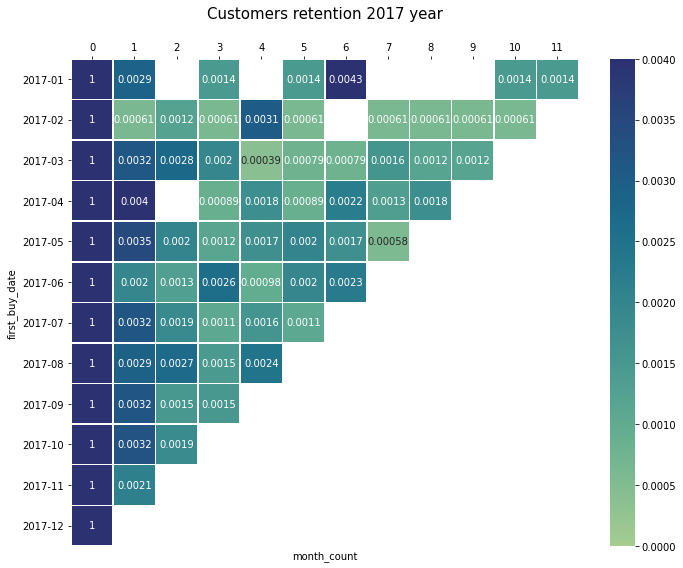

In [51]:
# Визуализируем полученные данные при помощи тепловой карты
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(data = retention, vmin = 0.0, vmax = 0.004, cmap = 'crest', annot = True, linewidth = 0.5)
ax.set_yticklabels(retention.index)
ax.xaxis.tick_top()
fig = ax.get_figure()
ax.set_title('Customers retention 2017 year\n', fontsize = 15)
plt.tight_layout()

Видим, что большинство пользователей делают 1 заказ. Возвращаемость ожидаемо максимальна в первые месяцы

# 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: 
- R - время от последней покупки пользователя до текущей даты
- F - суммарное количество покупок у пользователя за всё время
- M - сумма покупок за всё время

Подробно опиши, как ты создавал кластеры. 
Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, 
frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

In [52]:
# Используем наш "строенный" датафрейм со всеми данными. Для начала сразу удалим пропуски и оставим нужные статусы
customers_orders_items_RFM = customers_orders_items.dropna().query('order_status == ["processing", "shipped", "delivered"]')

In [53]:
# Будем считать, что текущая дата - это максимальная дата покупки + 1 день
now = customers_orders_items_RFM.order_approved_at.max() + timedelta(days=1)

In [55]:
customers_orders_items_RFM.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_month,weeks_count
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07,4.428571


In [56]:
# Найдем сразу все требуемые метрики
# R - время от последней покупки пользователя до текущей даты
# F - суммарное количество покупок у пользователя за всё время (покупка = заказ)
# M - сумма покупок за всё время
rfm = customers_orders_items_RFM.groupby('customer_unique_id', as_index = False) \
    .agg({'order_approved_at': lambda x:(now - x.max()).days, 'order_id': 'count', 'price': 'sum'}) \
    .rename(columns = {'order_approved_at': 'R', 'order_id': 'F', 'price': 'M'})

rfm

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00


- Recency (Давность) — Как давно клиент совершил покупку?
- Frequency (Частота) — Как часто они совершают покупки?
- Monetary Value (Денежная ценность) — Сколько они тратят? 

In [57]:
# Чтобы распределить пользователей по кластерам, используем квантили — составление частей на основе доступных значений 
# Нам нужно выявить явных "фаворитов" и "аутсайдеров", поэтому используем более крайние значения квантилей
quantiles = rfm.quantile(q=[0.1, 0.4, 0.7, 0.9])
quantiles

,R,F,M
0.1,42.0,1.0,25.98
0.4,177.0,1.0,69.90
0.7,312.0,1.0,139.00
0.9,465.0,2.0,279.99


In [58]:
# Из-за того, что клиенты в основном совершают 1 заказ, почти все квантили для метрики F получаются одинаковые
# Будем использовать собственную кластеризацию для всех метрик, с оглядкой на полученные квантили
rfm.F.value_counts()

1     81728
2      8795
3      1646
4       621
5       241
6       190
7        45
8        16
10       11
11       11
9        10
12        9
14        3
15        3
13        2
20        2
21        1
18        1
24        1
Name: F, dtype: int64

In [59]:
# Посмотрим на экстремальные значения метрик 
rfm.describe()

,R,F,M
count,93336.000000,93336.000000,93336.000000
mean,237.486093,1.180391,141.621663
std,152.569986,0.620913,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,24.000000,13440.000000


In [60]:
# Делим данные на сегменты при помощи pd.cut
rfm['R_categ'] = pd.cut(rfm.R, bins = [0, 32, 184, 367, 715], 
                                     labels = ['4', '3', '2', '1'])
rfm['F_categ'] = pd.cut(rfm.F, bins = [0, 1, 3, 6, 25], 
                                     labels = ['1', '2', '3', '4'])
rfm['M_categ'] = pd.cut(rfm.M, bins = [0, 20, 70, 140, 13450], 
                                     labels = ['1', '2', '3', '4'])

# Меняем тип данных на строковый
rfm['R_categ'] = rfm['R_categ'].astype(str)
rfm['F_categ'] = rfm['F_categ'].astype(str)
rfm['M_categ'] = rfm['M_categ'].astype(str)


# И соединяем оценку
rfm['RFM_score'] = rfm['R_categ'] + rfm['F_categ'] + rfm['M_categ']
rfm.head()

,customer_unique_id,R,F,M,R_categ,F_categ,M_categ,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,2,212
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214


Итак, для оценок использовались следующие границы метрик:

**R - время от последней покупки пользователя до текущей даты**
- 1: больше года
- 2: от полугода до года (6-12 месяцев)
- 3: 1-6 месяцев
- 4: 0-1 месяц

(первая цифра не включительно)

Эти значения удобнее использовать и ими оперировать, чем значениями рассчитанных ранее квантилей (но они близки друг к другу). Чем меньше срок от последней покупки - тем выше оценка

**F - суммарное количество покупок у пользователя за всё время (покупка = заказ, т.к. нам нужна частота покупок)**
- 1: 1 заказ
- 2: 2-3 заказа
- 3: 4-6 заказов
- 4: 7 и более заказов

Значения выбраны интуитивно, глядя на распределение rfm.F.value_counts(). Чем больше заказов - тем выше оценка

**M - сумма покупок за всё время**
- 1: 0-20
- 2: 20-70
- 3: 70-140
- 4: больше 140

(первая цифра не включительно)

Значения подобраны близкие к значениям рассчитанных ранее квантилей. Чем больше сумма - тем выше оценка

In [61]:
#  Рассчитаем число пользователей с группировкой по оценкам и их процентное содержание
rfm_count = rfm.groupby('RFM_score', as_index = False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns = {'customer_unique_id' : 'customer_count'}) \
    .sort_values('customer_count', ascending = False) 

rfm_count['customer_per'] = round((rfm_count['customer_count'] / rfm_count['customer_count'].sum()*100), 2)

rfm_count.head()

,RFM_score,customer_count,customer_per
15,212,11294,12.10
28,312,10382,11.12
16,213,8438,9.04
29,313,8284,8.88
17,214,7541,8.08


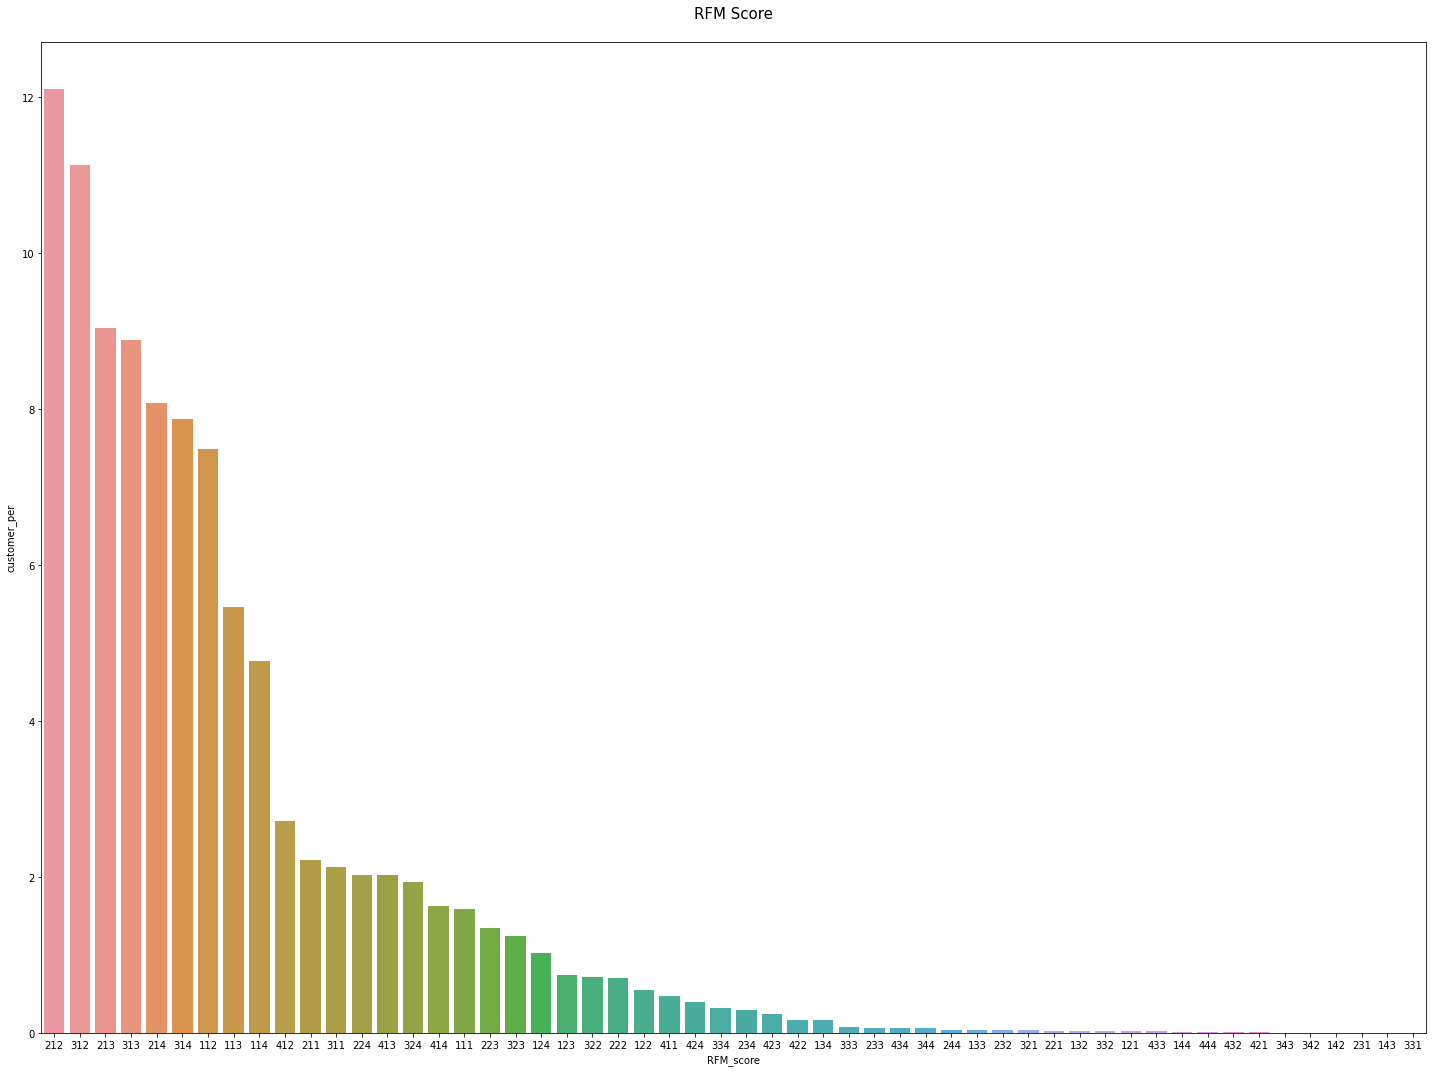

In [62]:
# Графическое представление распределения RFM_score
fig, ax = plt.subplots(figsize = (20, 15))
sns.barplot(data = rfm_count, x = 'RFM_score', y = 'customer_per')
ax.set_title('RFM Score\n', fontsize = 15)
plt.tight_layout()

Пользователи "111" покупали давно (более года назад), один раз и на маленькую сумму (до 20). О таких можно забыть.
Пользователи "444" покупают часто (больше 6 раз), на большую сумму (больше 140) и последняя покупка была недавно (до месяца). 
Таких клиентов стоит беречь и следить за изменениями по ним.
Пользователи "144", "244", "134", "133" и т.д. - лояльные, но потеряли активность, надо напомнить о себе.

Основная доля клиентов состоит в группах RFM "212" и "312" (последняя покупка от 1 до 6 месяцев назад, количество один, 
суммарный объем покупки 20-70).
Мы имеем дело с минимальными показателями retention, и невысоким средним чеком. 

Лучшие клиенты с RFM "444" составляют около 0.01 %

In [63]:
# Вычислим среднее значение метрик во всех сегментах и посмотрим на их распределение по сегментам
rfm_mean = rfm.groupby('RFM_score', as_index = False) \
    .agg({'R' : 'mean', 'F' : 'mean', 'M' : 'mean'})
rfm_mean.head()

,RFM_score,R,F,M
0,111,466.601210,1.0,15.925750
1,112,463.399799,1.0,46.060514
2,113,464.013535,1.0,103.785536
3,114,466.271583,1.0,333.677795
4,121,458.000000,2.0,16.214118


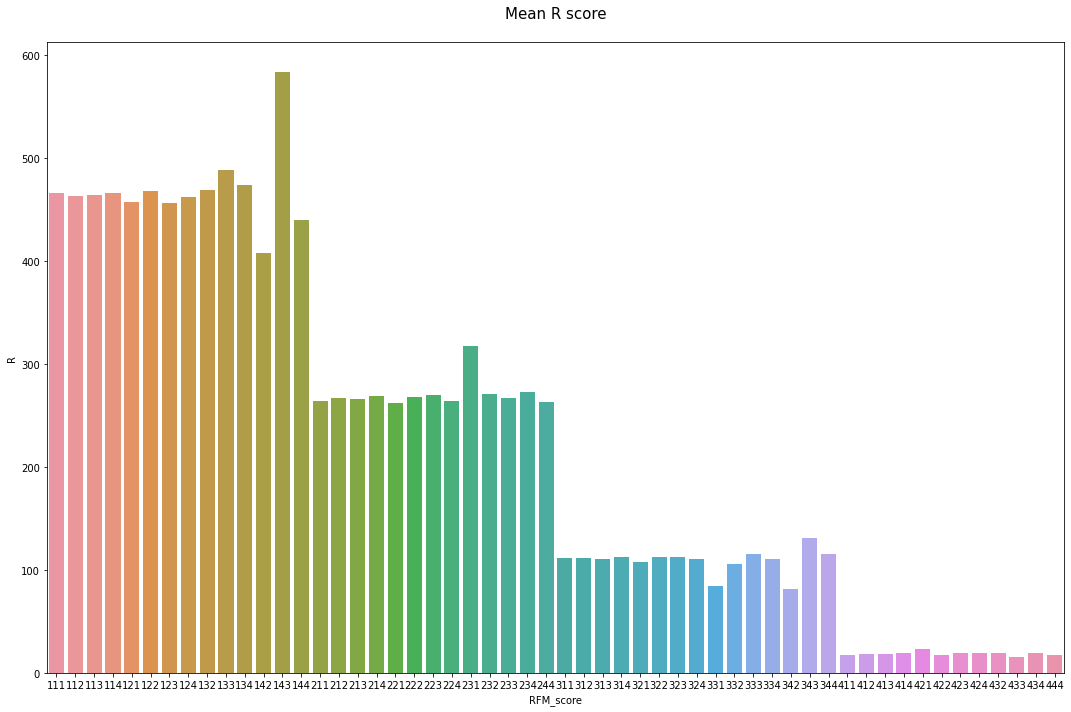

In [64]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'R')
ax.set_title('Mean R score\n', fontsize = 15)
plt.tight_layout()

На графике видим довольно равномерное уменьшение времени от последней покупки пользователя до текущей даты при увеличении 
первого числа сегмента (чем меньше дней, тем больше число)

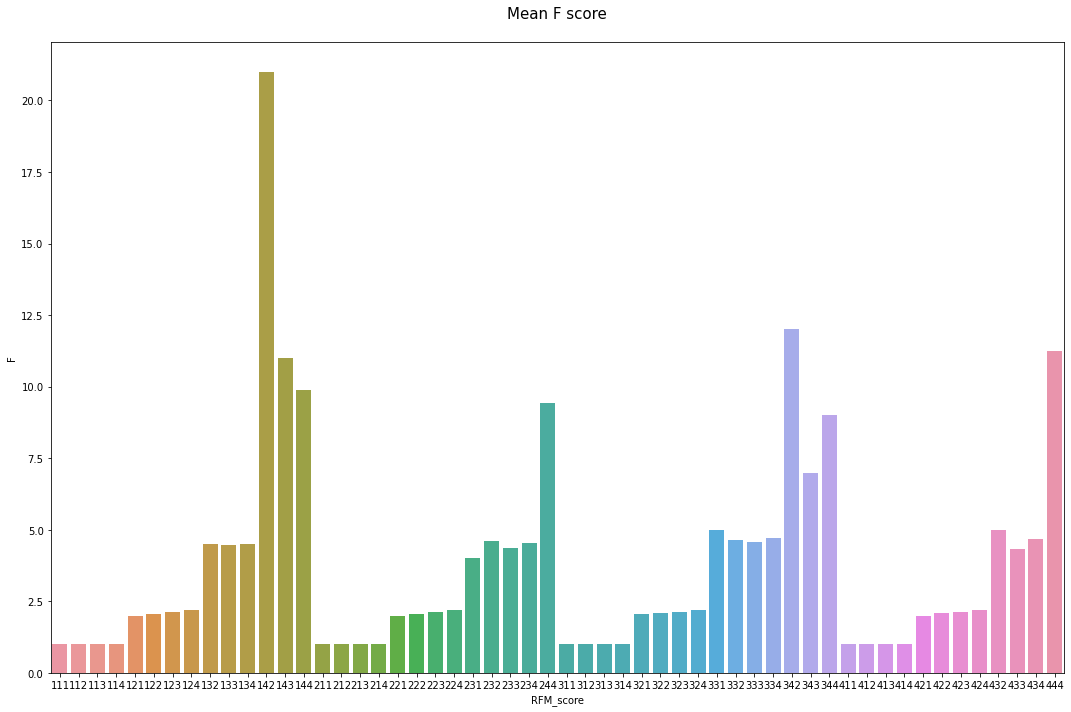

In [65]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'F')
ax.set_title('Mean F score\n', fontsize = 15)
plt.tight_layout()

Здесь у нас возрастает второе число в оценке, поэтому график имеет ступенькообразный вид. Максимальное количество заказов было у очень давних покупателей

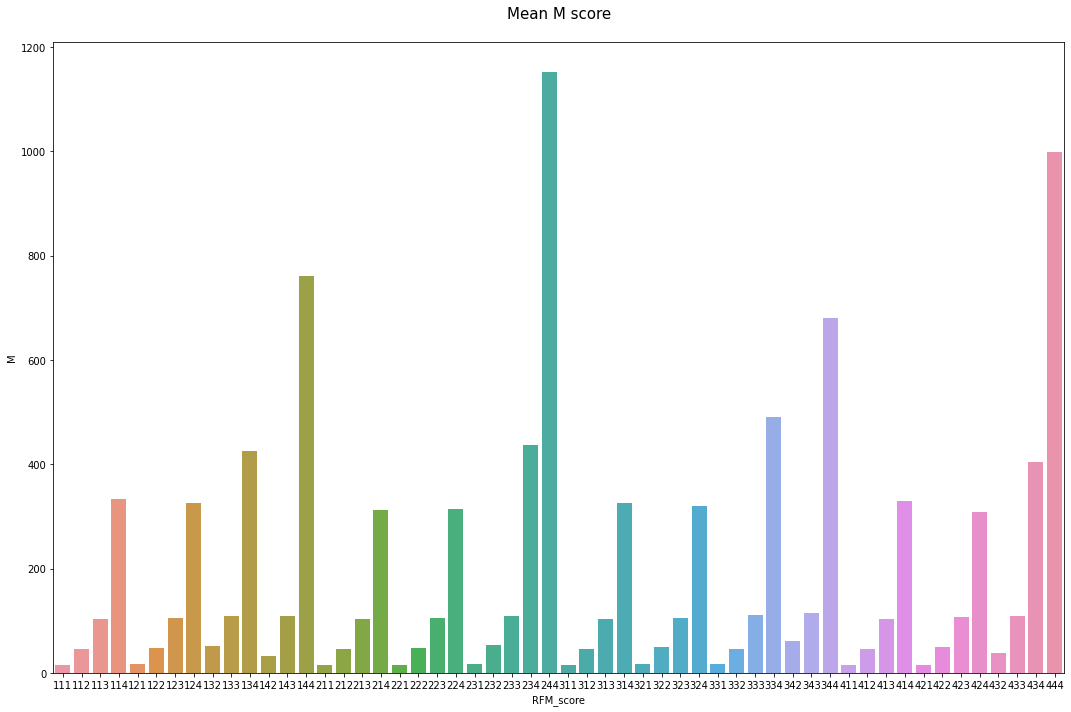

In [66]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'M')
ax.set_title('Mean M score\n', fontsize = 15)
plt.tight_layout()

Здесь также наблюдаем ступенькообразный вид графика